In [2]:
import itertools
import logging
import warnings
from pathlib import Path

import numpy as np
import pytorch_lightning as pl
import torch
from torchvision.utils import make_grid
from matplotlib import pyplot as plt
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import RichProgressBar, ModelCheckpoint

In [3]:
from zprp.models.cycle_gan.data import CycleGanDataModule
from zprp.models.cycle_gan.model import CycleGAN
from zprp.models.cycle_gan.components import SemanticRegularization

In [4]:
LOG_PATH = "lightning_logs"
LOG_NAME = "cyclegan_regularization_experiment"
DATA_PATH = Path("data")

In [5]:
torch.set_float32_matmul_precision("high")
# lightning complaining about using only one worker in DataLoader
warnings.filterwarnings("ignore", ".*does not have many workers.*")
# silence hardware summary on every `fit`
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

In [6]:
CONTENT_PATH = DATA_PATH / "photo/1"
STYLE_PATH = DATA_PATH / "monet/1"

In [7]:
def unnormalize(x: torch.Tensor) -> torch.Tensor:
    return (x * 0.5) + 0.5

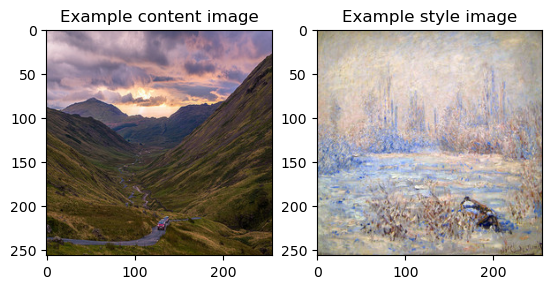

In [8]:
dm = CycleGanDataModule(content_path=CONTENT_PATH, style_path=STYLE_PATH, n_val_images=64, batch_size=16, img_size=256)
dm.setup("fit")

content_img, style_img = next(iter(dm.train_dataloader()))

fix, axes = plt.subplots(1, 2)

axes[0].imshow(np.transpose(unnormalize(content_img[0]), axes=(1, 2, 0)))
axes[0].set_title("Example content image")
axes[1].imshow(np.transpose(unnormalize(style_img[0]), axes=(1, 2, 0)))
axes[1].set_title("Example style image")
plt.show()

In [9]:
epochs = 30

In [10]:
plt.rcParams["figure.figsize"] = (14, 8)


def show_images(model, title):
    device = torch.device("cuda") if torch.cuda.is_available else torch.device("cpu")

    model.eval()
    model.g.eval()
    model.f.eval()

    images_x, images_y = next(iter(dm.val_dataloader()))
    images_x = images_x[:16].to(device)
    images_y = images_y[:16].to(device)

    with torch.no_grad():
        fake_y = model.x_to_y(images_x)
        cycle_x = model.y_to_x(fake_y)
        fake_x = model.y_to_x(images_y)
        cycle_y = model.x_to_y(fake_x)

    fig, axes = plt.subplots(2, 3)

    axes[0][0].imshow(make_grid(unnormalize(images_x), nrow=4).permute(1, 2, 0).cpu())
    axes[0][0].set_title("Real photo")
    axes[0][1].imshow(make_grid(unnormalize(fake_y), nrow=4).permute(1, 2, 0).cpu())
    axes[0][1].set_title("Fake painting")
    axes[0][2].imshow(make_grid(unnormalize(cycle_x), nrow=4).permute(1, 2, 0).cpu())
    axes[0][2].set_title("Recreated photo")

    axes[1][0].imshow(make_grid(unnormalize(images_y), nrow=4).permute(1, 2, 0).cpu())
    axes[1][0].set_title("Real painting")
    axes[1][1].imshow(make_grid(unnormalize(fake_x), nrow=4).permute(1, 2, 0).cpu())
    axes[1][1].set_title("Fake photo")
    axes[1][2].imshow(make_grid(unnormalize(cycle_y), nrow=4).permute(1, 2, 0).cpu())
    axes[1][2].set_title("Recreated painting")

    for ax in axes.reshape(-1):
        ax.axis("off")

    if title:
        fig.suptitle(title, size=22)

    plt.show()

## Semantic regularization

In [11]:
data_iter= iter(dm.train_dataloader())

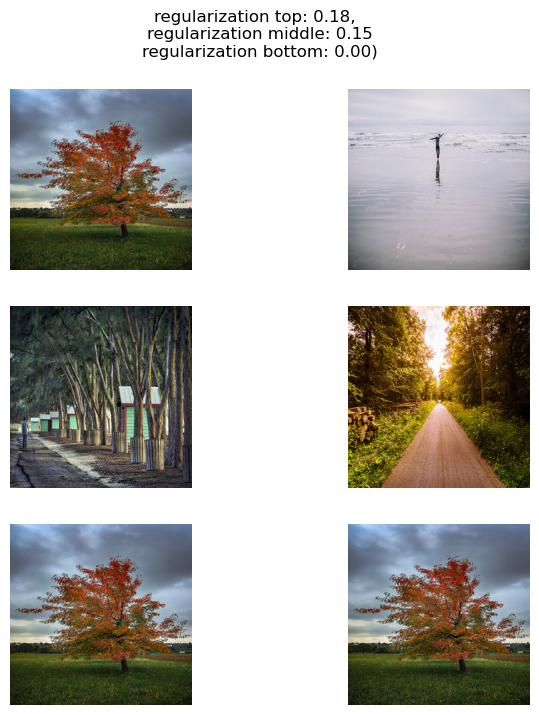

In [14]:
img_batch = next(data_iter)[0]
img_batch1, img_batch2 = img_batch[:2], img_batch[2:]

img1, img2 = (
    unnormalize(img_batch1[0].detach().cpu()).permute(1, 2, 0),
    unnormalize(img_batch1[1].detach().cpu()).permute(1, 2, 0),
)
img3, img4 = (
    unnormalize(img_batch2[0].detach().cpu()).permute(1, 2, 0),
    unnormalize(img_batch2[1].detach().cpu()).permute(1, 2, 0),
)

semantic_regularization = SemanticRegularization(beta_param=1)

regularization1_2 = semantic_regularization(img_batch1[0].unsqueeze(0), img_batch1[1].unsqueeze(0))
regularization3_4 = semantic_regularization(img_batch2[0].unsqueeze(0), img_batch2[1].unsqueeze(0))
regularization1_1 = semantic_regularization(img_batch1[0].unsqueeze(0), img_batch1[0].unsqueeze(0))

fig, axes = plt.subplots(
    3,
    2,
    figsize=(8, 8),
)
for ax in axes.reshape(-1):
    ax.axis("off")
axes[0, 0].imshow(img1)
axes[0, 1].imshow(img2)
axes[1, 0].imshow(img3)
axes[1, 1].imshow(img4)
axes[2, 0].imshow(img1)
axes[2, 1].imshow(img1)
fig.suptitle(
    f"regularization top: {regularization1_2:.2f},  \n"
    f"regularization middle: {regularization3_4:.2f}\n"
    f"regularization bottom: {regularization1_1:.2f})"
)
plt.show()

images with more semantically similar content have lower regularization values

# Training
$$
L(G, F, D_X, D_Y) = \mathcal{L}_{GAN}(G, D_Y, X, Y) + \mathcal{L}_{GAN}(F, D_X, Y, X) + \lambda \mathcal{L}_{cyc}(G, F)
$$
from https://arxiv.org/pdf/1703.10593
- update the discriminators with \mathcal{L}_{GAN} (adversarial losses)
- update the generators with \mathcal{L}_{GAN} and \mathcal{L}_{cyc} (adversarial and cycle consistency losses)

In [15]:
lambdas = [0, 0.5, 1, 2]
betas = [10 ** (-2), 10 ** (-1), 1, 10]

for lambda_param, beta_param in itertools.product(lambdas, betas):
    tb_logger = pl_loggers.TensorBoardLogger(save_dir=LOG_PATH, name=f"{LOG_NAME}_l{lambda_param}")

    class TestSemanticRegularization(SemanticRegularization):
        def __init__(self) -> None:
            super().__init__(beta_param=beta_param)

    model = CycleGAN(
        lambda_param=lambda_param,
        RegularizationClass=TestSemanticRegularization,
        optimizer_kwargs={"lr": 0.0002, "betas": (0.5, 0.999)},
    )

    periodic_callback = ModelCheckpoint(
        save_top_k=-1,
        every_n_epochs=5,
        filename="checkpoint_periodic-{epoch:04d}",
    )

    trainer = pl.Trainer(
        max_epochs=epochs,
        logger=tb_logger,
        log_every_n_steps=1,
        callbacks=[
            RichProgressBar(refresh_rate=1),
            periodic_callback,
        ],
    )
    trainer.fit(model, dm)

    model.eval()
    show_images(model, f"CycleGAN with lambda = {lambda_param}, regularization beta = {beta_param}")

Missing logger folder: lightning_logs/cyclegan_regularization_experiment_l1


┏━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name                   ┃ Type                       ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ g                      │ Generator                  │ 11.4 M │
│ 1 │ f                      │ Generator                  │ 11.4 M │
│ 2 │ dx                     │ Discriminator              │  2.8 M │
│ 3 │ dy                     │ Discriminator              │  2.8 M │
│ 4 │ lsgan_loss             │ LSGANLoss                  │      0 │
│ 5 │ cycle_consistency_loss │ CycleConsistencyLoss       │      0 │
│ 6 │ regularization         │ TestSemanticRegularization │ 11.2 M │
└───┴────────────────────────┴────────────────────────────┴────────┘

Trainable params: 39.4 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 39.4 M                                                                                               
Total estimated model params size (MB): 157

Output()

OutOfMemoryError: CUDA out of memory. Tried to allocate 16.00 MiB. GPU 0 has a total capacity of 3.81 GiB of which 15.12 MiB is free. Including non-PyTorch memory, this process has 3.70 GiB memory in use. Of the allocated memory 3.59 GiB is allocated by PyTorch, and 25.56 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)